<a href="https://colab.research.google.com/github/dougscohen/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [0]:
import numpy as np
import pandas as pd

# Read in the data
df = pd.read_csv('shot_logs.csv')

In [3]:
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [4]:
# Get the percentage of made vs. missed shots in the data

df['SHOT_RESULT'].value_counts(normalize=True)

missed    0.547861
made      0.452139
Name: SHOT_RESULT, dtype: float64

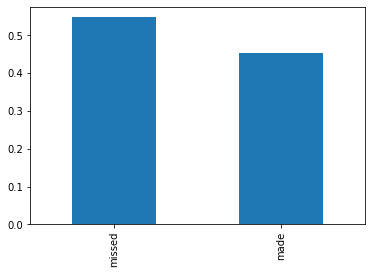

In [5]:
# Plot the percentage visually

df['SHOT_RESULT'].value_counts(normalize=True).plot(kind='bar')

 Choose your target. Which column in your tabular dataset will you predict?

`Shot Result will be my target. It will be a classifcation problem.`

 Is your problem regression or classification?
 
 `Classification`

 How is your target distributed? How many classes? Are the classes imbalanced?
 
 ` My target is pretty evenly distributed. Is is binary with 2 classes, made and missed`


Choose your evaluation metric(s).

`I will use accuracy as the main metric, but will also test precision, recall, and ROC AUC as well.`

 Choose which observations you will use to train, validate, and test your model.

`The data is on shots from October 2014-March 2015, so I will definitely do a time-based split. I will probably make my train data on 2014 shots, my validate data on Jan-2015 shots, and my test data on shots after Jan-2015 (i.e. Feb and March)`

 Begin to clean and explore your data.

In [6]:
# Create a set that includes the part of 'MATCHUP' that is just the date

dates = []
for date in df['MATCHUP']:
  dates.append(date[:12])
set(dates)

{'DEC 01, 2014',
 'DEC 02, 2014',
 'DEC 03, 2014',
 'DEC 04, 2014',
 'DEC 05, 2014',
 'DEC 06, 2014',
 'DEC 07, 2014',
 'DEC 08, 2014',
 'DEC 09, 2014',
 'DEC 10, 2014',
 'DEC 11, 2014',
 'DEC 12, 2014',
 'DEC 13, 2014',
 'DEC 14, 2014',
 'DEC 15, 2014',
 'DEC 16, 2014',
 'DEC 17, 2014',
 'DEC 18, 2014',
 'DEC 19, 2014',
 'DEC 20, 2014',
 'DEC 21, 2014',
 'DEC 22, 2014',
 'DEC 23, 2014',
 'DEC 25, 2014',
 'DEC 26, 2014',
 'DEC 27, 2014',
 'DEC 28, 2014',
 'DEC 29, 2014',
 'DEC 30, 2014',
 'DEC 31, 2014',
 'FEB 01, 2015',
 'FEB 02, 2015',
 'FEB 03, 2015',
 'FEB 04, 2015',
 'FEB 05, 2015',
 'FEB 06, 2015',
 'FEB 07, 2015',
 'FEB 08, 2015',
 'FEB 09, 2015',
 'FEB 10, 2015',
 'FEB 11, 2015',
 'FEB 12, 2015',
 'FEB 19, 2015',
 'FEB 20, 2015',
 'FEB 21, 2015',
 'FEB 22, 2015',
 'FEB 23, 2015',
 'FEB 24, 2015',
 'FEB 25, 2015',
 'FEB 26, 2015',
 'FEB 27, 2015',
 'FEB 28, 2015',
 'JAN 01, 2015',
 'JAN 02, 2015',
 'JAN 03, 2015',
 'JAN 04, 2015',
 'JAN 05, 2015',
 'JAN 06, 2015',
 'JAN 07, 2015

In [7]:
# create new column on the dataframe with the date that each shot was taken

df['DATE'] = dates

df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,DATE
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,"MAR 04, 2015"
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,"MAR 04, 2015"
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,"MAR 04, 2015"
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,"MAR 04, 2015"
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,"MAR 04, 2015"


In [0]:
# Change 'DATE' column datetype to datetime format

df['DATE'] = pd.to_datetime(df['DATE'], infer_datetime_format=True)

In [9]:
df['DATE']

0        2015-03-04
1        2015-03-04
2        2015-03-04
3        2015-03-04
4        2015-03-04
            ...    
128064   2014-10-29
128065   2014-10-29
128066   2014-10-29
128067   2014-10-29
128068   2014-10-29
Name: DATE, Length: 128069, dtype: datetime64[ns]

In [10]:
# Split the data into training, validation, and testing data based on time
train = df[df['DATE'].dt.month >= 10]
val = df[df['DATE'].dt.month <= 1]
test = df[(df['DATE'].dt.month == 2) | (df['DATE'].dt.month == 3)]

# Print the shape of each
train.shape, val.shape, test.shape

((68735, 22), (33262, 22), (26072, 22))

 Begin to choose which features, if any, to exclude. Would some features "leak" future information?

 `I would exclude the 'FGM' column as that is essentially a duplicate of my target column.`

In [0]:
def convert_to_seconds(cell):
  ''' Define a funtion that takes a cell with minutes and seconds, and converts
      it to just seconds'''
  Y = (int(cell.split(':')[0]) * 60) + (int(cell.split(':')[1]))
  return Y

In [0]:
def wrangle(X):

  # Prevent SettingWithCopyWarning
  X = X.copy()

  # feature engineer a column that is just second on the game clock using the 
  #. function I created above
  X['game_clock_in_seconds'] = X['GAME_CLOCK'].apply(convert_to_seconds)

  # Drop duplicate features
  duplicates = ['FGM', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_id', 'MATCHUP']
  X = X.drop(columns=duplicates)

  # Drop features that are "future information" to our model
  futures = ['W', 'SHOT_NUMBER', 'FINAL_MARGIN', 'PTS']
  X = X.drop(columns=futures)

  return X

In [13]:
# wrangle all 3 of our datasets

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Print the shape of each wrangled dataset

train.shape, val.shape, test.shape

((68735, 15), (33262, 15), (26072, 15))

In [14]:
train.head()

,GAME_ID,LOCATION,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSE_DEF_DIST,player_name,DATE,game_clock_in_seconds
178,21400478,A,2,7:03,9.3,0,0.8,22.0,3,made,"Brewer, Corey",8.9,brian roberts,2014-12-31,423
179,21400478,A,4,10:00,14.3,10,10.2,13.4,2,missed,"Terry, Jason",3.2,brian roberts,2014-12-31,600
180,21400478,A,4,8:52,0.3,3,6.1,21.5,2,missed,"Terry, Jason",2.5,brian roberts,2014-12-31,532
181,21400478,A,4,7:40,16.2,7,6.1,19.2,2,missed,"Smith, Josh",4.8,brian roberts,2014-12-31,460
182,21400478,A,4,7:08,14.7,0,0.7,22.5,3,missed,"Terry, Jason",3.4,brian roberts,2014-12-31,428


In [15]:
# Establish a baseline accuracy (if we guessed 'Missed', we would be right
#. roughly 54% of the time)

train['SHOT_RESULT'].value_counts(normalize=True)

missed    0.543813
made      0.456187
Name: SHOT_RESULT, dtype: float64

In [0]:
# Create X features matrices and and y target vectors

target = 'SHOT_RESULT'

X_train = train.drop(columns=[target, 'DATE'])
y_train = train[target]

X_val = val.drop(columns=[target, 'DATE'])
y_val = val[target]

X_test = test.drop(columns=[target, 'DATE'])
y_test = test[target]

In [0]:
%%capture

!pip install category_encoders

In [27]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline model with Random Forest Classifier
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=3, n_jobs=-1, min_samples_leaf=10)
)

# Fit the model on the training set
pipeline.fit(X_train, y_train)

# Accuracy Scores
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.8183021750200044
Validation Accuracy: 0.6188443268594793


In [22]:
# XGBoost
from xgboost import XGBClassifier

# Create pipeline with XGBoost Classifier as the model
pipeline_2 = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=3, n_jobs=-1)
)

# Fit the model on train
pipeline_2.fit(X_train, y_train)

# Score on validation
from sklearn.metrics import accuracy_score
y_pred = pipeline_2.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

Validation Accuracy: 0.6220311466538392


## Permutation Importances

In [28]:
# Create a pipeline with just encoding and imputing

transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean')
)

# Fit pipeline on train, transform on val
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

# Random Forest model fit on the transformed data above
model = RandomForestClassifier(random_state=3, n_jobs=-1, min_samples_leaf=10)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [0]:
%%capture

!pip install eli5

In [31]:
# import eli5 libary
import eli5
from eli5.sklearn import PermutationImportance

# create a permuter that will calculate permutation importances
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=3
)

# Fit the permuter to the tranformed validation data
permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=10,
                                                       min_samples_split=2,
                                                       min_weight_f

In [42]:
# Create a list of feature names so that we can put in in a panda series with 
#. the feature importances

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

SHOT_DIST                0.083615
CLOSE_DEF_DIST           0.009639
TOUCH_TIME               0.008526
SHOT_CLOCK               0.001696
PTS_TYPE                 0.001581
PERIOD                   0.000505
CLOSEST_DEFENDER         0.000451
GAME_ID                  0.000000
DRIBBLES                -0.000078
game_clock_in_seconds   -0.000752
player_name             -0.000806
LOCATION                -0.000974
GAME_CLOCK              -0.001185
dtype: float64

In [43]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0836 ± 0.0033,SHOT_DIST
0.0096 ± 0.0013,CLOSE_DEF_DIST
0.0085 ± 0.0038,TOUCH_TIME
0.0017 ± 0.0014,SHOT_CLOCK
0.0016 ± 0.0020,PTS_TYPE
0.0005 ± 0.0006,PERIOD
0.0005 ± 0.0009,CLOSEST_DEFENDER
0 ± 0.0000,GAME_ID
-0.0001 ± 0.0012,DRIBBLES
-0.0008 ± 0.0011,game_clock_in_seconds


In [0]:
# create a mask where the minimum feature importance is at least 0 weight

minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance

# apply the mask to our training data
features = X_train.columns[mask]
X_train_masked = X_train[features]

In [49]:
# Apply mask to validation data
X_val_masked = X_val[features]

# use pipeline from above but this time fit on masked train data
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=3, n_jobs=-1, min_samples_leaf=10)
)

# Fit on train, score on val
pipeline.fit(X_train_masked, y_train)
print('Validation Accuracy', pipeline.score(X_val_masked, y_val))

Validation Accuracy 0.6190247128855751


In [50]:
pipeline_2 = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=3, n_jobs=-1)
)

# use the other pipeline but this time fit on masked train data
pipeline_2.fit(X_train_masked, y_train)

from sklearn.metrics import accuracy_score
y_pred = pipeline_2.predict(X_val_masked)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

Validation Accuracy: 0.6213396668871385
